# Prestige Bias model

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from scipy import stats
from numba import jit
from scipy import interpolate
from scipy import optimize
from scipy import special
from scipy import signal
import random
import scipy.stats as st
import gc
from scipy.integrate import quad 
from scipy import optimize

In [2]:
N = 10000 # generation size
A = np.random.normal(0, 1, size=N)
A.shape

(10000,)

In [3]:
a = [2,4,6]
list(filter(lambda x: x>3,a))

[4, 6]

In [4]:
b,J = 1,1
A_hat = 1
alpha = 0.5

print(f'b={b}\tJ={J}\tA_hat={A_hat}\t alpha={alpha:.2f}')

b=1	J=1	A_hat=1	 alpha=0.50


In [5]:
def bias(traits,b=b,J=J,A_hat=A_hat):
    return b * np.exp(-(((A_hat - traits) ** 2) / (2*J)))

def probability_err(p,n,ci=0.95):
    prob_interval_values = {
        0.5:0.67449,
        0.75:1.15035,
        0.9:1.64485,
        0.95:1.96,
        0.97:2.17009
    }
    
    return 2*prob_interval_values[ci]*np.sqrt((p*(1-p))/n)

def continous_err(data):
    conf_interval = st.t.interval(0.95, len(data)-1, loc=data.mean(), scale=st.sem(data))
    return (conf_interval[1] - conf_interval[0])/2

def influence_bias(traits,b,J,success_correlated=True):
    inf_bias = bias(traits,b,J)
    return inf_bias if success_correlated else (1-inf_bias)
    
def is_converging(mean,var,conv_val=A_hat,mean_tol=0.01,var_tol=0.007):
    return np.abs(mean-conv_val) <= mean_tol and var <= var_tol

def mean_distance_from_opt(arr,opt=A_hat):
    return ((arr-opt)**2).mean()

def get_convergence_index(arr,n=5):
    count = 0
    for index,val in enumerate(arr):
        if val:
            count += 1
        else:
            count = 0
        if count == n:
            return index-n   
    

def plot_model(data):
    fig, ax = plt.subplots()
    binary = len(data.shape)==1

    if binary:
        data = data[~np.isnan(data)]
        
        window = min(len(data),51)
        window = window - 1 if window%2 == 0 else window
        
        smoothed_data = signal.savgol_filter(data,window,5)
        
        ax.plot(range(len(data)),smoothed_data,label='indicator freq')
    else:
        ax.plot((0,len(data.shape[1])),(A_hat,A_hat),label='A_hat',linestyle='--')

## Influence advantage

In [6]:
def find_opt(alpha, traits, K):
    alpha=alpha[0]
    if alpha < 0 or alpha > 1:
        return -np.inf
    prestige = traits*alpha + (1-alpha)*K
    prestige /= prestige.sum()
    errors = (A_hat-traits)**2
    res = (errors*prestige).sum()
    return res


def choose_influence(A_,eta,const_alpha=None):
    e = np.random.normal(0, scale = eta, size=len(A_))
    K = np.zeros(len(A_))
    alphas = []
    outs = []
    for i in range(len(A_)):
        biased_A = bias(A_,b,J,A_hat)+e[i]
        if const_alpha:
            alpha = const_alpha
        else:    
            if i == 0:
                alpha,out = 1,1
            else:
                alpha,out,*_ = optimize.brute(find_opt,[(0.00001,1)],args=(biased_A, K),disp=False,full_output=True, finish=None)
                
        alphas.append(alpha)
        prestige = biased_A*alpha + (1-alpha)*K
        prestige /= prestige.sum()
        chosen_role_model = np.searchsorted(prestige.cumsum(), np.random.uniform())
        K[chosen_role_model] += 1
        if const_alpha:
            out = (A_hat-A_[chosen_role_model])**2
        outs.append(out)
        
    return alphas,outs

A_ = np.random.normal(0,1, size=200)
results = [np.array([choose_influence(A_,η) for _ in range(300)]) for η in [0.0001,0.001,0.01]]

In [7]:
alphas = [result[:,0].mean(axis=0) for result in results]
α_errs = [continous_err(result[:,0]) for result in results]
outs = [result[:,1].mean(axis=0) for result in results]
outs_errs = [continous_err(result[:,1]) for result in results]

/home/saar/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/saar/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [8]:
avg_outs = []
errs = []
for α in np.linspace(0.01,1,num=30):
    results = [np.array([choose_influence(A_,η,α) for _ in range(300)]) for η in [0.0001,0.001,0.01]]
    avg_out = [result[:,1].mean(axis=0).mean() for result in results]
    err = [continous_err(result[:,1].mean(axis=0)) for result in results]
    avg_outs.append(avg_out)
    errs.append(err)

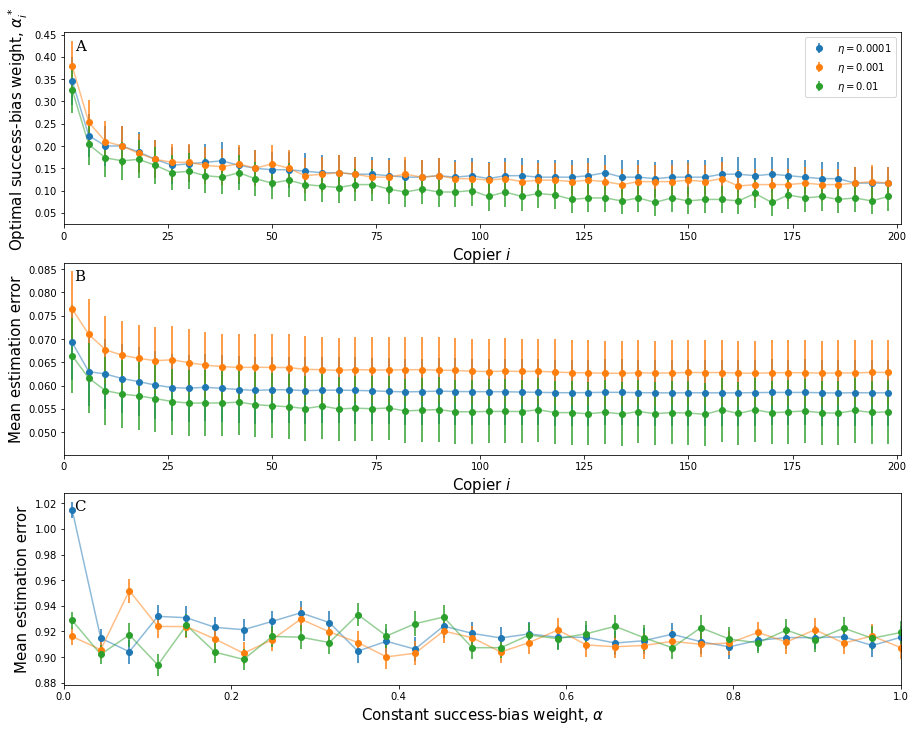

In [9]:
fig, axs = plt.subplot_mosaic([['a'],['b'],['c']],figsize=[15,12])
listify = lambda x,i: [y[i] for y in x]

axs['a'].set_xlabel(r'Copier $i$',fontsize=15)
axs['a'].set_ylabel(r'Optimal success-bias weight, $\alpha^*_i$',fontsize=15)
axs['a'].errorbar(range(2, len(alphas[0])+1)[::4], alphas[0][1::4],yerr=α_errs[0][1::4],fmt='o',label=r'$\eta=0.0001$',color='#1f77b4')
axs['a'].plot(range(2, len(alphas[0])+1)[::4],alphas[0][1::4],alpha=0.5,color='#1f77b4')
axs['a'].errorbar(range(2, len(alphas[1])+1)[::4], alphas[1][1::4],yerr=α_errs[1][1::4],fmt='o',label=r'$\eta=0.001$',color='#ff7f0e')
axs['a'].plot(range(2, len(alphas[1])+1)[::4],alphas[1][1::4],alpha=0.5,color='#ff7f0e')
axs['a'].errorbar(range(2, len(alphas[2])+1)[::4], alphas[2][1::4],yerr=α_errs[2][1::4],fmt='o',label=r'$\eta=0.01$',color='#2ca02c')
axs['a'].plot(range(2, len(alphas[2])+1)[::4],alphas[2][1::4],alpha=0.5,color='#2ca02c')
axs['a'].set_xlim(0, A_.size+1)
axs['a'].legend()

axs['b'].set_xlabel(r'Copier $i$',fontsize=15)
axs['b'].set_ylabel('Mean estimation error',fontsize=15)
axs['b'].errorbar(range(2, len(outs[0])+1)[::4],outs[0][1::4],yerr=outs_errs[0][1::4],fmt='o',label=r'$\eta=0.0001$',color='#1f77b4');
axs['b'].plot(range(2, len(outs[0])+1)[::4],outs[0][1::4],alpha=0.5,color='#1f77b4')
axs['b'].errorbar(range(2, len(outs[1])+1)[::4],outs[1][1::4],yerr=outs_errs[1][1::4],fmt='o',label=r'$\eta=0.001$',color='#ff7f0e');
axs['b'].plot(range(2, len(outs[1])+1)[::4],outs[1][1::4],alpha=0.5,color='#ff7f0e')
axs['b'].errorbar(range(2, len(outs[2])+1)[::4],outs[2][1::4],yerr=outs_errs[2][1::4],fmt='o',label=r'$\eta=0.01$',color='#2ca02c');
axs['b'].plot(range(2, len(outs[2])+1)[::4],outs[2][1::4],alpha=0.5,color='#2ca02c')
axs['b'].set_xlim(0, A_.size+1)

axs['c'].errorbar(np.linspace(0.01,1,num=30),listify(avg_outs,0),yerr=listify(errs,1),fmt='o',color='#1f77b4')
axs['c'].plot(np.linspace(0.01,1,num=30),listify(avg_outs,0),alpha=0.5,color='#1f77b4')
axs['c'].errorbar(np.linspace(0.01,1,num=30),listify(avg_outs,1),yerr=listify(errs,1),fmt='o',color='#ff7f0e')
axs['c'].plot(np.linspace(0.01,1,num=30),listify(avg_outs,1),alpha=0.5,color='#ff7f0e')
axs['c'].errorbar(np.linspace(0.01,1,num=30),listify(avg_outs,2),yerr=listify(errs,1),fmt='o',color='#2ca02c')
axs['c'].plot(np.linspace(0.01,1,num=30),listify(avg_outs,2),alpha=0.5,color='#2ca02c')
axs['c'].set_xlabel(r'Constant success-bias weight, $\alpha$',fontsize=15)
axs['c'].set_ylabel('Mean estimation error',fontsize=15)
axs['c'].set_xlim(0, 1)

for label, ax in axs.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.001, 0.99, label.upper(), transform=ax.transAxes + trans,
            fontsize=15, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none'))



plt.savefig('figures/choose_bias.pdf');

## Numeric validation

In [10]:
def single_DM_generation(A_,alpha,mutation=None):
    alpha_tag = alpha/(1-alpha)
    if mutation:
        A_ += np.random.normal(0, scale = mutation, size=len(A_))
    prestige = bias(A_,b,J,A_hat)*alpha_tag
    dist = np.random.dirichlet(prestige)
    K = np.random.multinomial(len(A_),dist)
    return K


def single_GT_generation(A_,alpha,mutation=None):
    if mutation:
        A_ += np.random.normal(0, scale = mutation, size=len(A_))
    biased_A = bias(A_,b,J,A_hat)*alpha
    K = np.zeros(len(A_))
    for _ in range(len(A_)):
        prestige = biased_A + (1-alpha)*K
        prestige /= prestige.sum()
        chosen_role_model = np.searchsorted(prestige.cumsum(),np.random.rand())
        K[chosen_role_model] += 1
    
    return K
    
    
def get_bias(A_,alpha=None):
    if alpha:
        alpha_tag = alpha/(1-alpha)
        biased = bias(A_,b,J,A_hat)*alpha_tag
    else:
        biased = bias(A_,b,J,A_hat)
        
    return biased/biased.sum()
    
    
def get_expected(A_,alpha):
    alpha_tag = alpha/(1-alpha)
    prestige = bias(A_,b,J,A_hat)*alpha_tag
    prestige /= prestige.sum()
    K = len(A_)*prestige
    return K


def chi_squared_p_val(o,e):
    return stats.chisquare(o,e)[1]

In [11]:
DMs = []
dists = []
hists_GT=[]
hists_DM =[]
A_ = np.random.normal(0,1, size=100)
alpha = 0.5
m = 100
for i in range(m):
    o_GT = single_GT_generation(A_.copy(),alpha)
    dists.append(o_GT)
    hists_GT.append(np.histogram(o_GT, bins=np.arange(len(o_GT)+1))[0])
    o_DM = single_DM_generation(A_.copy(),alpha)
    DMs.append(o_DM)
    hists_DM.append(np.histogram(o_DM, bins=np.arange(len(o_DM)+1))[0])
    
hists_dists_avg = np.array(hists_GT).mean(axis=0)
hists_DMs_avg = np.array(hists_DM).mean(axis=0)

### DM

In [12]:
from scipy.special import gamma, factorial

def logpdf(x, alphas):
    k = len(x)
    n = np.sum(x)
    sum_alphas = np.sum(alphas)

    d = np.log(factorial(n))
    d += np.log(gamma(sum_alphas))
    d -= np.log(gamma(n + sum_alphas))

    for i in range(k):
        d += np.log(gamma(x[i] + alphas[i]))
        d -= np.log(factorial(x[i]))
        d -= np.log(gamma(alphas[i]))

    return d


def loglik(α, X):
    if not ((0 < α) & (α < 1)).all():
        return -np.inf
    return np.sum([logpdf(x, alphas=α) for x in X])

In [13]:
alpha_tag = alpha/(1-alpha)
prestige = bias(A_,b,J,A_hat)*alpha_tag

In [14]:
loglik(prestige, np.array(DMs))

-11744.979285325704

In [15]:
lls = []
prestige_ = prestige.copy()
for _ in range(5000):
    np.random.shuffle(prestige_)
    lls.append(loglik(prestige_,  np.array(DMs)))
lls = np.array(lls)

<ipython-input-16-5033d12d9078>:4: RuntimeWarning: divide by zero encountered in true_divide
  rel_error = abs(hists_DMs_avg-hists_dists_avg)[:30]/hists_DMs_avg[:30]
<ipython-input-16-5033d12d9078>:4: RuntimeWarning: invalid value encountered in true_divide
  rel_error = abs(hists_DMs_avg-hists_dists_avg)[:30]/hists_DMs_avg[:30]


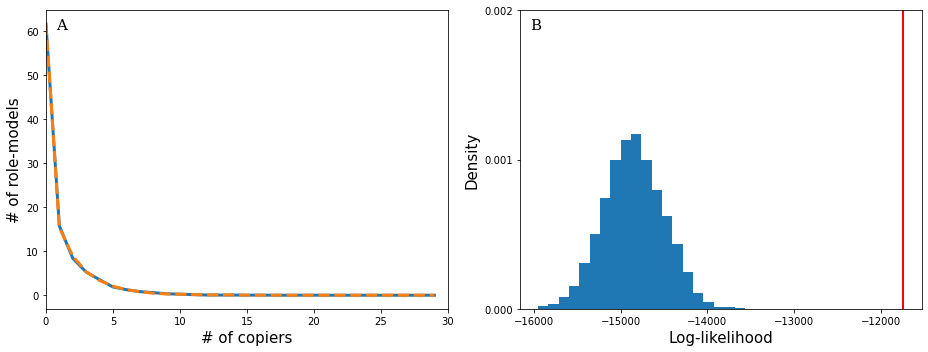

In [16]:
fig, axs = plt.subplot_mosaic([['a','b']],figsize=[13,5])

idx = hists_DMs_avg
rel_error = abs(hists_DMs_avg-hists_dists_avg)[:30]/hists_DMs_avg[:30]
axs['a'].plot(range(30), hists_dists_avg[:30], '-', markersize=2, lw=3, label='Model')
axs['a'].plot(range(30), hists_DMs_avg[:30], '--', markersize=2, lw=3, label='DM')
axs['a'].set_xlabel('# of copiers',fontsize=15)
axs['a'].set_ylabel('# of role-models',fontsize=15);
axs['a'].set_xlim(0,30)


axs['b'].hist(lls, 20, density=True)
axs['b'].axvline(loglik(prestige, np.array(DMs)), color='r', lw=2);
axs['b'].set_xlabel('Log-likelihood',fontsize=15)
axs['b'].set_ylabel('Density',fontsize=15);
axs['b'].set_yticks([0, 0.001, 0.002])

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.001, 0.99, label.upper(), transform=ax.transAxes + trans,
        fontsize=15, verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='none', edgecolor='none'))
    
fig.tight_layout()
plt.savefig('figures/DM_validation.pdf')

### GBD

In [17]:
p_vals = []
dists = []
A_ = np.random.normal(0,1, size=2000)
alpha = 0.1
mutation = 0
E = get_expected(A_.copy(),alpha)
m = 1000
for i in range(m):
    o_GT = single_GT_generation(A_.copy(),alpha,mutation)
    dists.append(o_GT)
    _,p_val = stats.chisquare(o_GT,E)
    p_vals.append(p_val)
    
dists_avg = np.array(dists).mean(axis=0)

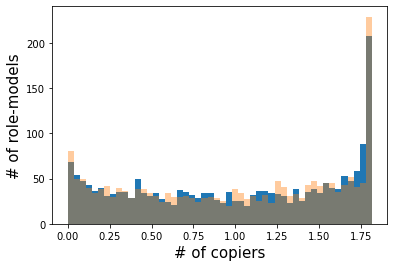

In [18]:
mod_dists = dists_avg.copy()
mod_dists[mod_dists>E.max()]=E.max()

plt.xlabel('# of copiers',fontsize=15)
plt.ylabel('# of role-models',fontsize=15)
plt.hist(E,bins=50)
plt.hist(mod_dists,bins=50,alpha=0.4)
plt.savefig('figures/GBD_validation.pdf')

### Validations

In [19]:
p_val = chi_squared_p_val(np.ones(len(A_)),E)
print(f'the p value of the expected uniform distribution is: {p_val}')

the p value of the expected uniform distribution is: 0.0


In [20]:
rv = stats.multinomial(len(A_),get_bias(A_,alpha))
p_val = chi_squared_p_val(dists[87],E)
print(f'the p value of the expected multinomial distribution is: {p_val}')

the p value of the expected multinomial distribution is: 0.0


## Dirichlet Approximation Model

In [21]:
@jit(nopython=True)
def make_array_from_copiers(K,original):
    new_arr = np.zeros(len(K))
    i=0
    for index,copiers in enumerate(K):
        for _ in range(int(copiers)):
            new_arr[i]= original[index]
            i= i+ 1
    return new_arr

In [22]:
def prestige_dirichlet(A_,m=1000,binary=False,mutation_scale=0,
                       b=b,J=J,alpha=0.5,A_hat=A_hat,conv_tol=0,k=None,l=None):
    B_hat = A_[A_!=A_hat][0]
    np.random.seed()
    if binary:
        p = np.empty(m)
    else:    
        p = np.empty((2,m))
    p[:] = np.nan
    
    i=0
    while True:
        if binary and not np.isnan(p[-1]):
            addition = np.empty(m)
            addition[:] = np.nan
            p = np.array(list(p)+ list(addition))
        if binary:
            p[i]=len(A_[A_==A_hat])/len(A_)
        else:
            p[0,i]=A_.mean()
            p[1,i]=A_.var()
        
        A_converge = (np.abs(A_-A_[0]) <= conv_tol).all()
        if A_converge:
            break
        
        if mutation_scale > 0 and not binary:
            A_ += np.random.normal(0, scale = mutation_scale, size=len(A_))
        
        alpha_tag = alpha/(1-alpha)
        if k and i%(k+l)>k:
            prestige = bias(A_,b,J,B_hat)*alpha_tag
        else:
            prestige = bias(A_,b,J,A_hat)*alpha_tag
        
        dist = np.random.dirichlet(prestige)
        K = np.random.multinomial(len(A_),dist)
        A_ = make_array_from_copiers(K,A_)
        i += 1
    
    return p

### Test binary model

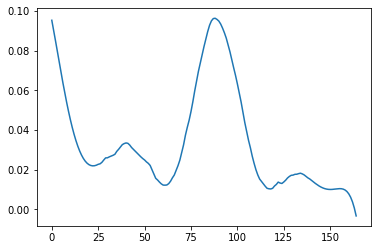

In [23]:
A_ = np.zeros(1000)
A_[:100] = A_hat
A_[A_==0] = A_hat*0.9
data = prestige_dirichlet(A_,binary=True,J=1)
plot_model(data)

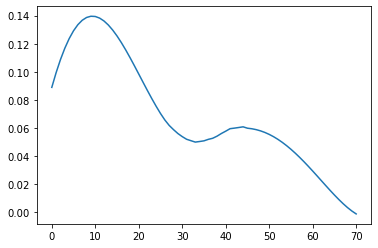

In [24]:
A_ = np.zeros(1000)
A_[:100] = A_hat
A_[A_==0] = A_hat*0.9
data = prestige_dirichlet(A_,binary=True,J=1,k=100,l=10)
plot_model(data)

## GT model

### Binary model

In [25]:
def binary_GT_model(A_,m=1000,b=b,J=J,alpha=alpha,A_hat=A_hat,conv_tol=0):
    np.random.seed()
    
    p = np.empty(m)
    p[:] = np.nan
    
    i = 0
    while True:
        if not np.isnan(p[-1]):
            addition = np.empty(m)
            addition[:] = np.nan
            p = np.array(list(p)+ list(addition))
        
        p[i]=len(A_[A_==A_hat])/len(A_)
        
        A_converge = (np.abs(A_-A_[0]) <= conv_tol).all()
        if A_converge:
            break
            
        new_A = []
        copiers = np.random.rand(len(A_))
        K = np.zeros(len(A_))
        for j in range(len(A_)):
            if isinstance(J,(list,np.ndarray)):
                biased_A = bias(A_,b,J[j])*alpha
            else:
                biased_A = bias(A_,b,J)*alpha
                
            prestige = biased_A + (1-alpha)*K
            prestige /= prestige.sum()
            chosen_role_model = np.searchsorted(prestige.cumsum(),copiers[j])
            K[chosen_role_model] += 1
            new_A.append(A_[chosen_role_model])
        A_ = np.array(new_A)
        i+=1
        
    return p

### Continous model

# Parallel computing

In [27]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import as_completed
from functools import partial


def compute_model_parallel(A_,model,reps=100,max_workers=None):
    futures = []
    with ProcessPoolExecutor(max_workers) as executor:
        for _ in range(int(reps)):
            f = executor.submit(model,A_.copy())
            futures.append(f)

    results = []
    for data in as_completed(futures): 
        results.append(data.result())
    
    return results 

def gt_binary_model_parallel(A_,reps=100,b=b,J=J,alpha=alpha,max_workers=10):
    fixed_model = partial(binary_GT_model,b=b,J=J,alpha=alpha,A_hat=A_hat)
    return compute_model_parallel(A_,fixed_model,reps,max_workers=max_workers)
    
def dirichlet_model_parallel(A_,reps=100,binary=True,mutation_scale=0,conv_tol=0,b=b,J=J,alpha=alpha
                             ,k=None,l=None,max_workers=10):
    fixed_model = partial(prestige_dirichlet,binary=binary,mutation_scale=mutation_scale,
                          conv_tol=conv_tol,b=b,J=J,alpha=alpha,k=k,l=l)
    return compute_model_parallel(A_,fixed_model,reps,max_workers=max_workers) 

## Continous model results aggregation

### Test Dirichlet model

# Binary model

In [28]:
def aggregate_binary_model_with_errors(res,A_hat,sample_size,ci=0.95):
    fixation_count = 0
    fixation_gens = []
    mean_growth_rate = 0
    diffs = []
    for arr in res:
        arr = arr[~np.isnan(arr)]
        if arr[-1]==1:
            fixation_count += 1
            fixation_gens.append(len(arr))
            
            diff = np.diff(arr).mean()
            diffs.append(diff)
        
    fixation_gens = np.array(fixation_gens)
    fixation_prob = fixation_count/len(res)
    if fixation_prob == 0:
        fixation_prob_err = 0
        fixation_gen_mean = 0
        fixation_gen_err = 0
        mean_growth_rate = 0
    else:    
        fixation_prob_err = probability_err(fixation_prob,sample_size,ci)
        fixation_gen_mean = fixation_gens.mean()
        fixation_conf = st.t.interval(ci, len(fixation_gens)-1, loc=fixation_gen_mean, scale=st.sem(fixation_gens))
        fixation_gen_err = (fixation_conf[1] - fixation_conf[0])/2
        mean_growth_rate = np.array(diffs).mean()
    
    return fixation_prob,fixation_prob_err,fixation_gen_mean,fixation_gen_err,mean_growth_rate

## Kimura's equations

In [29]:
def kimura(p0,s,N):
    numer = 1 - np.exp(-2*s*N*p0)
    denom = 1 - np.exp(-2*s*N)
    return numer/denom


def effective_population(N,alpha):
    return alpha*N + (1-alpha)
    

def durret(x,alpha,beta,N):
    Ne = effective_population(N,alpha)
    numer = 1 - np.exp(-2*(1-beta)*Ne*x)
    denom = 1 - np.exp(-2*(1-beta)*Ne)
    return numer/denom


def durret_change_env(x,alpha,s_n,N):
    Ne = effective_population(N,alpha)
    numer = 1 - np.exp(-2*s_n*Ne*x)
    denom = 1 - np.exp(-2*s_n*Ne)
    return numer/denom

In [30]:
def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0]


def I1(N, s, x):
    if x == 1:
        return 0
    return (1 - np.exp(-2*N*s*x) - np.exp(-2 * N * s * (1 - x)) + np.exp(-2 * N *s)) / (x*(1-x))


def I2(N, s, x):
    if x == 0:
        return 0
    return -np.expm1(2 * N * s * x) * np.expm1(-2 * N * s * x) / (x * (1 - x))


@np.vectorize
def T_kimura(n0, N, s):
    x = n0 / N
    J1 = -1.0 / (s * np.expm1(-2 * N * s)) * integral(I1, N, s, x, 1)
    u = np.expm1(-2 * N * s * x) / np.expm1(-2 * N * s)
    J2 = -1.0 / (s * np.expm1(-2 * N *s)) * integral(I2, N, s, 0, x)
    return J1 + ((1 - u) / u) * J2

## Test models

### Test Dirichlet model

In [31]:
N = 1000
p0 = 1e-3
A = A_hat*0.7
alpha = 0.4
J=1
A_ = np.zeros(N)
A_[:int(p0*N)] = A_hat
A_[A_==0] = A
beta = bias(A,J=J,A_hat=A_hat)
results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30)

aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
fixation_prob,fixation_prob_err,fixation_gen_mean,fixation_gen_err,growth_rate = aggregated_results

print(f'fixation probability and estimated error: {fixation_prob} \t {fixation_prob_err}')
print(f'durret probability: {durret(p0,alpha,beta,N):.4f}')
print(f'fixation growth rate and mean fixation time:{growth_rate:.4f} \t {fixation_gen_mean}')
print(f'beta:{beta:.4f}')

fixation probability and estimated error: 0.0321 	 0.006909614662019872
durret probability: 0.0346
fixation growth rate and mean fixation time:0.0059 	 179.72585669781932
beta:0.9560


### Test Wright-Fisher fixation probability

In [32]:
def wf_fix_prob(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    n[:] = n0 # broadcasting
    update = (n > 0) & (n < N)
    while update.any():
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
    return (n == N).mean()


N = 10000
s = 1e-3
p0 = 1e-4
reps = 10000
n0 = p0*N

p = wf_fix_prob(n0, N, s, reps)
print(f'fixation probability and probability error: {p}\t{probability_err(p,N):.4f}')
print(f'kimura probability: {kimura(p0,s,N):.4f}')

fixation probability and probability error: 0.0016	0.0016
kimura probability: 0.0020


### Test Wright-Fisher fixation time

In [33]:
def wf_fix_time_with_err(results):
    is_fixed,times = results
    fixation_gens = times[is_fixed]
    fixation_gen_mean = fixation_gens.mean()
    fixation_conf = st.t.interval(0.95, len(fixation_gens)-1, loc=fixation_gen_mean, scale=st.sem(fixation_gens))
    fixation_gen_err = (fixation_conf[1] - fixation_conf[0])/2
    
    return fixation_gen_mean,fixation_gen_err
    


def wf_fix_time_sim(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    T = np.repeat(np.inf, repetitions)
    
    t = 0
    n[:] = n0
    update = (n > 0) & (n < N)
    while update.any():        
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
        t += 1
        T[~update] = np.minimum(T[~update], t)
    return n == N, T


N = effective_population(1000,0.2)
s = 1-0.956
p0 = 1e-4
reps = 10000
n0 = p0*N
t,t_err = wf_fix_time_with_err(wf_fix_time_sim(n0, N, s, reps))
print(f'fixation time and error: {t:.2f}\t\t\t{t_err:.4f}')
print(f'kimura fixation time: {T_kimura(n0, N, s):.4f}')

fixation time and error: 155.44			19.2464
kimura fixation time: 154.0194


## Compare DM vs WF

### Variating $\alpha$

In [34]:
alphas = np.linspace(start=1e-4,stop=0.999,num=30)
N = 1000
p0 = 1e-3
A = A_hat*0.7
A_ = np.zeros(N)
A_[:int(p0*N)] = A_hat
A_[A_==0] = A
β = bias(A,J=J,A_hat=A_hat)

sim_res_alpha = []
for alpha in alphas:
    results = dirichlet_model_parallel(A_,binary=True,reps=10000,J=J,alpha=alpha,max_workers=60)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    fixation_prob,fixation_prob_err,fix_time,fix_time_err,_ = aggregated_results
    
    durr = durret(p0,alpha,β,N)
    
    sim_res_alpha.append((fixation_prob,fixation_prob_err,durr,fix_time,fix_time_err))

In [35]:
wf_res_alpha = []
s = 1-β
for alpha in alphas:
    Ne = effective_population(N,alpha)
    n0 = p0*Ne
    p = wf_fix_prob(n0, Ne, s, reps)
    p_err = probability_err(p,reps)
    t,t_err = wf_fix_time_with_err(wf_fix_time_sim(n0, Ne, s, reps))
    kim = T_kimura(n0, Ne, s)
    wf_res_alpha.append((p,p_err,t,t_err,kim,Ne))

/home/saar/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/saar/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


### Varying $\beta$

In [36]:
trait_modifiers = np.linspace(start=0.01,stop=0.99,num=30)
N = 1000
alpha = 0.01
p0 = 1e-3
sim_res_beta = []
ci = 0.75
for mod in trait_modifiers:
    A = A_hat*mod
    beta = bias(A,J=J,A_hat=A_hat)
    
    A_ = np.zeros(N)
    A_[:int(p0*N)] = A_hat
    A_[A_==0] = A
    results = dirichlet_model_parallel(A_,binary=True,reps=10000,J=J,alpha=alpha,max_workers=60)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results),ci=ci)
    fixation_prob,fixation_prob_err,fix_time,fix_time_err,_ = aggregated_results
    
    durr = durret(p0,alpha,beta,N)
    
    sim_res_beta.append((fixation_prob,fixation_prob_err,durr,fix_time,fix_time_err,beta))

In [37]:
neg_betas = 1 - np.array([tup[-1] for tup in sim_res_beta])
Ne = effective_population(N,alpha)
wf_res_s = []

for s in neg_betas:
    n0 = p0*Ne
    p = wf_fix_prob(n0, Ne, s, reps)
    p_err = probability_err(p,reps,ci)
    t,t_err = wf_fix_time_with_err(wf_fix_time_sim(n0, Ne, s, reps))
    kim = T_kimura(n0, Ne, s)
    wf_res_s.append((p,p_err,t,t_err,kim))

### Plot

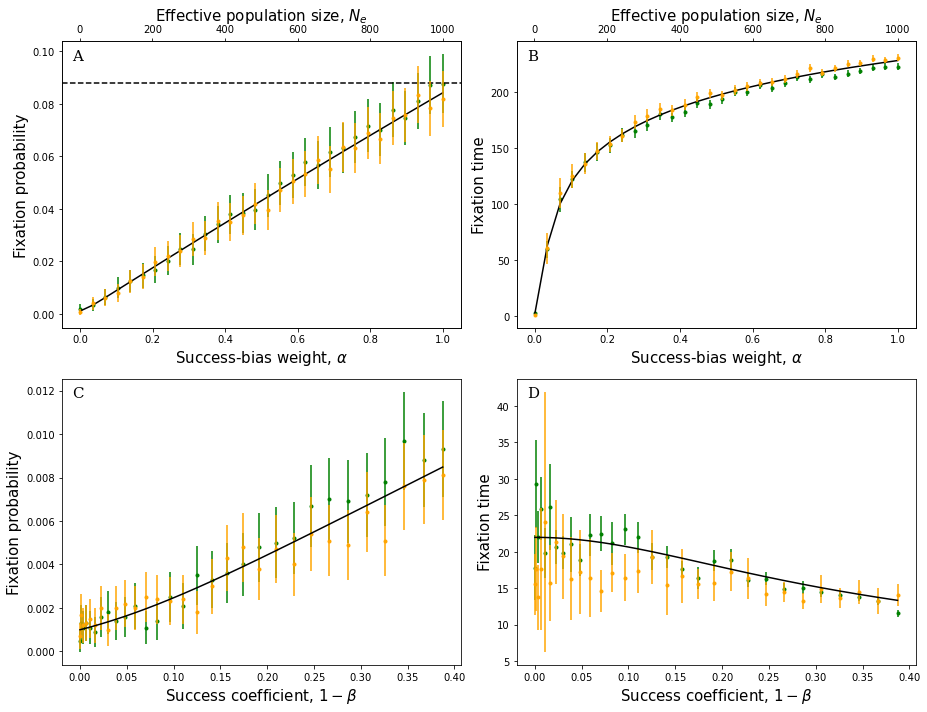

In [38]:
Y = [tup[0] for tup in sim_res_alpha]
Y_err = [tup[1] for tup in sim_res_alpha]
durrs = [tup[2] for tup in sim_res_alpha]

Y_wf = [tup[0] for tup in wf_res_alpha]
Y_wf_err = [tup[1] for tup in wf_res_alpha]
Nes = [tup[-1] for tup in wf_res_alpha]


fig, axs = plt.subplot_mosaic([['a','b'],['c','d']],figsize=[13,10])

ax2 = axs['a'].twiny()

axs['a'].set_xlabel(r'Success-bias weight, $\alpha$',fontsize=15)
ax2.set_xlabel(r'Effective population size, $N_e$',fontsize=15)
axs['a'].set_ylabel('Fixation probability',fontsize=15)
l1 = axs['a'].axhline(2*(1-β), ls='--', label=r'2s$',color='k')
l2 = axs['a'].plot(alphas,durrs,label= 'kimura',zorder=2,color='k')
l3 = axs['a'].errorbar(alphas,Y,yerr=Y_err,fmt='o',color='green',markersize=3,zorder=1)
l4 = ax2.errorbar(Nes,Y_wf,yerr=Y_wf_err,fmt='o',color='orange',zorder=0,markersize=3);

lns = (l1,l2[0],l3[0],l4[0])
labs = [l1.get_label(),l2[0].get_label(),'DM simulations','WF simulations']

Y = [tup[3] for tup in sim_res_alpha]
Y_err = [tup[4] for tup in sim_res_alpha]

Y_wf = [tup[2] for tup in wf_res_alpha]
Y_wf_err = [tup[3] for tup in wf_res_alpha]
kims = [tup[4] for tup in wf_res_alpha]

ax2 = axs['b'].twiny()

axs['b'].set_xlabel(r'Success-bias weight, $\alpha$',fontsize=15)
ax2.set_xlabel(r'Effective population size, $N_e$',fontsize=15)
axs['b'].set_ylabel('Fixation time',fontsize=15)
l1 = axs['b'].plot(alphas,kims,label= 'kimura',zorder=2,color='k')
l2 = axs['b'].errorbar(alphas,Y,yerr=Y_err,fmt='o',color='green',markersize=3,zorder=1)
l3 = ax2.errorbar(Nes,Y_wf,yerr=Y_wf_err,fmt='o',color='orange',zorder=0,markersize=3);

lns = (l1[0],l2[0],l3[0])
labs = [l1[0].get_label(),'DM simulations','WF simulations']



Y = [tup[0] for tup in sim_res_beta]
Y_err = [tup[1] for tup in sim_res_beta]
durrs = [tup[2] for tup in sim_res_beta]

Y_wf = [tup[0] for tup in wf_res_s]
Y_wf_err = [tup[1] for tup in wf_res_s]


axs['c'].set_xlabel(r'Success coefficient, $1-\beta$',fontsize=15)
axs['c'].set_ylabel('Fixation probability',fontsize=15)
axs['c'].plot(neg_betas,durrs,zorder=2,label='kimura',color='k')
axs['c'].errorbar(neg_betas,Y,yerr=Y_err,fmt='o',label='DM simulations',zorder=0,markersize=3,color='g');
axs['c'].errorbar(neg_betas,Y_wf,yerr=Y_wf_err,fmt='o',label='WF simulations',zorder=1,markersize=3,color='orange');


Y = [tup[3] for tup in sim_res_beta]
Y_err = [tup[4] for tup in sim_res_beta]

Y_wf = [tup[2] for tup in wf_res_s]
Y_wf_err = [tup[3] for tup in wf_res_s]
kims = [tup[4] for tup in wf_res_s]


axs['d'].set_xlabel(r'Success coefficient, $1-\beta$',fontsize=15)
axs['d'].set_ylabel('Fixation time',fontsize=15)
axs['d'].plot(neg_betas,kims,zorder=2,label='kimura',color='k')
axs['d'].errorbar(neg_betas,Y,yerr=Y_err,fmt='o',label='DM simulations',zorder=0,markersize=3,color='g');
axs['d'].errorbar(neg_betas,Y_wf,yerr=Y_wf_err,fmt='o',label='WF simulations',zorder=1,markersize=3,color='orange');



for label, ax in axs.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.001, 0.99, label.upper(), transform=ax.transAxes + trans,
            fontsize=15, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none'))

plt.tight_layout()
plt.savefig('figures/kimura_var.pdf')

## Compare DM vs full model

In [39]:
def plot_binary_comparison(x_axis,full_res,dm_res,x_name,log_scale=False,kims=None):
    fig, axs = plt.subplot_mosaic([['a','b']],figsize=[10,5])
    listify = lambda x,i: [y[i] for y in x]
    
    axs['a'].set_ylabel('Fixation probability',fontsize=15)
    axs['a'].set_xlabel(x_name,fontsize=15)
    l1 = axs['a'].errorbar(x_axis,listify(full_res,0),yerr=listify(full_res,1),fmt='-o',alpha=0.5)
    l2 = axs['a'].errorbar(x_axis,listify(dm_res,0),yerr=listify(dm_res,1),fmt='-*')
    l3 = axs['a'].axhline(kims[0], color='k')
    
    limit = (max(np.mean(listify(full_res,1)),np.mean(listify(dm_res,1))))*3
    axs['a'].set_ylim([kims[0]-limit, kims[0]+limit])

    axs['b'].set_ylabel('Fixation time',fontsize=15)
    axs['b'].set_xlabel(x_name,fontsize=15)
    axs['b'].errorbar(x_axis,listify(full_res,2),yerr=listify(full_res,3),fmt='-o',alpha=0.5)
    axs['b'].errorbar(x_axis,listify(dm_res,2),yerr=listify(dm_res,3),fmt='-*')
    axs['b'].axhline(kims[1],color='k')
    
    limit = (max(np.mean(listify(full_res,3)),np.mean(listify(dm_res,3))))*3
    axs['b'].set_ylim([kims[1]-limit, kims[1]+limit])
    
    if log_scale:
        axs['a'].set_xscale('log')
        axs['b'].set_xscale('log')
        
    for label, ax in axs.items():
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0.001, 0.99, label.upper(), transform=ax.transAxes + trans,
            fontsize=15, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='none', edgecolor='none'))

    fig.tight_layout()

### Number of simulations

In [ ]:
num_reps = np.linspace(100,5000,30)
N=1000
alpha=0.5
A_ = np.zeros(N)
J=1
A_[0] = A_hat
A_[A_==0] = A_hat*0.7
beta = bias(A_hat*0.7,J=J)
Ne = effective_population(N,alpha)
kims = (durret(1e-3,alpha,beta,N),T_kimura(1, Ne, 1-beta))
gt_results = []
dm_results = []

for reps in num_reps:
    full_results = gt_binary_model_parallel(A_,reps=reps,J=J,alpha=alpha,max_workers=10)
    aggregated_results = aggregate_binary_model_with_errors(full_results,A_hat,len(results))
    gt_results.append(aggregated_results)

    results = dirichlet_model_parallel(A_,binary=True,reps=reps,J=J,alpha=alpha,max_workers=10)
    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    dm_results.append(aggregated_results)

In [ ]:
plot_binary_comparison(num_reps,gt_results,dm_results,x_name='# of simulations',kims=kims)
plt.savefig('figures/num_sims.pdf')

### Estimation error

In [ ]:
N=1000
alpha=0.1
A_ = np.zeros(N)
A_[0] = A_hat
A_[A_==0] = A_hat*0.7
mutations = np.logspace(-7,-1,30)
reps = 5000
orig_J = 1
gt_results = []
dm_results = []
Ne = effective_population(N,alpha)
beta = bias(A_hat*0.7,J=orig_J)
kims = (durret(1e-3,alpha,beta,N),T_kimura(1, Ne, 1-beta))
for mutation in mutations:
    J = np.random.normal(orig_J, scale = mutation, size=len(A_))
    
    full_results = gt_binary_model_parallel(A_,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(full_results,A_hat,len(results))
    gt_results.append(aggregated_results)

    results = dirichlet_model_parallel(A_,binary=True,reps=reps,J=orig_J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    dm_results.append(aggregated_results)

In [ ]:
plot_binary_comparison(mutations,gt_results,dm_results,x_name=r'Estimation-error variance, $\eta ^2$',log_scale=True,kims=kims)
plt.savefig('figures/full_vs_dm_mutation.pdf')

### Heterogenous $\alpha$

In [ ]:
N=1000
alpha=0.5
A_ = np.zeros(N)
J=1
A_[0] = A_hat
A_[A_==0] = A_hat*0.7
scales = np.logspace(-7,-1,30)
reps = 5000
Ne = effective_population(N,alpha)
beta = bias(A_hat*0.7,J=J)
kims = (durret(1e-3,alpha,beta,N),T_kimura(1, Ne, 1-beta))
gt_results = []
dm_results = []
for scale in scales:
    normal_alpha = np.random.normal(alpha, scale = scale, size=len(A_))
    
    full_results = gt_binary_model_parallel(A_,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(full_results,A_hat,len(results))
    gt_results.append(aggregated_results)

    results = dirichlet_model_parallel(A_,binary=True,reps=reps,J=J,alpha=alpha,max_workers=60)
    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    dm_results.append(aggregated_results)

In [ ]:
plot_binary_comparison(scales,gt_results,dm_results,x_name=r'Success-bias weight variance,$\epsilon$',log_scale=True,kims=kims)
plt.savefig('figures/full_vs_dm_changing_alpha.pdf')

## Changing environment

In [ ]:
N = 1000
p0 = 1/N
A = A_hat*0.9
alpha = 0.1
J=1
A_ = np.zeros(N)
A_[0] = A_hat
A_[1:] = A
beta = bias(A, J=J, A_hat=A_hat)
k,l=20,80
s_n = ((k-l)/(k+l))*(1-beta)
Ne = effective_population(N, alpha)

print(fr's_n:{s_n:.4f}')
print(f'beta:{beta:.4f}')
print(f'Ne:{Ne}')
print(f'envch fix prob: {durret_change_env(p0,alpha,s_n,N):.4g}')
print(f'const fix prob: {durret(p0,alpha,beta,N):.4g}')
print(f'envch fix time: {T_kimura(p0*N,Ne,s_n):.4g}')
print(f'const fix time: {T_kimura(p0*N,Ne,1-beta):.4g}')

results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30,k=k,l=l)

aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
fixation_prob,fixation_prob_err,fixation_gen_mean,fixation_gen_err,growth_rate = aggregated_results

print(f'fixation probability and estimated error: {fixation_prob:.4g} \t {fixation_prob_err:.4g}')
print(f'fixation time and estimated error:{fixation_gen_mean:.4g} \t {fixation_gen_err:.4g}')

### Variating $\alpha$

In [ ]:
alphas = np.linspace(start=1e-4,stop=0.999,num=30)


N = 1000
p0 = 1/N
A = A_hat*0.9
J=1
A_ = np.zeros(N)
A_[0] = A_hat
A_[1:] = A
beta = bias(A, J=J, A_hat=A_hat)
k,l=30,80
s_n = ((k-l)/(k+l))*(1-beta)
ci=0.75
sim_res_alpha = []
for alpha in alphas:
    ch_res = durret_change_env(p0,alpha,s_n,N)
    const_res = durret(p0,alpha,beta,N)
    results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30,k=k,l=l)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results),ci=ci)
    fixation_prob,prob_err,*_ = aggregated_results
    
    sim_res_alpha.append((ch_res,fixation_prob,prob_err,const_res))
    
sim_res_alpha = np.array(sim_res_alpha)
Ne = effective_population(N, alphas)

### Variating $\beta$

In [ ]:
trait_modifiers = np.linspace(start=0.01,stop=0.99,num=30)


N = 1000
p0 = 1/N
J=1
A_ = np.zeros(N)
alpha = 0.1
k,l=30,80

sim_res_beta = []
for mod in trait_modifiers:
    A = A_hat*mod
    A_[0] = A_hat
    A_[1:] = A
    beta = bias(A,J=J,A_hat=A_hat)
    s_n = ((k-l)/(k+l))*(1-beta)
    
    ch_res = durret_change_env(p0,alpha,s_n,N)
    const_res = durret(p0,alpha,beta,N)
    results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30,k=k,l=l)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results))
    fixation_prob,prob_err,*_ = aggregated_results
    
    sim_res_beta.append((ch_res,fixation_prob,prob_err,const_res,1-beta))
    
sim_res_beta = np.array(sim_res_beta)

### Variating $k,l$

In [ ]:
n=100
ks = np.arange(1,n,5)

N = 1000
p0 = 1/N
A = A_hat*0.8
J=1
A_ = np.zeros(N)
A_[0] = A_hat
A_[1:] = A
beta = bias(A, J=J, A_hat=A_hat)
alpha=0.1


sim_res_k_l = []
for k in ks:
    l = n-k
    if k==l:
        continue
    
    s_n = ((k-l)/n)*(1-beta)
    
    ch_res = durret_change_env(p0,alpha,s_n,N)
    const_res = durret(p0,alpha,beta,N)
    results = dirichlet_model_parallel(A_,reps=10000,binary=True,J=J,alpha=alpha,max_workers=30,k=k,l=l)

    aggregated_results = aggregate_binary_model_with_errors(results,A_hat,len(results),ci=0.75)
    fixation_prob,prob_err,*_ = aggregated_results
    
    sim_res_k_l.append((ch_res,fixation_prob,prob_err,const_res,k-l))
    
sim_res_k_l = np.array(sim_res_k_l)

In [ ]:
fig, axs = plt.subplot_mosaic([['a','b'],['c','d']],figsize=[13,10])
axs2 = axs['a'].twiny()

axs2.plot(Ne,sim_res_alpha[:,0],label='changing env')
axs['a'].errorbar(alphas,sim_res_alpha[:,1],yerr=sim_res_alpha[:,2],fmt='o',markersize=3,label='simulations',color='C1')
axs2.set_xlabel(r'Effective population size, $N_e$',fontsize=15)
axs['a'].set_xlabel(r'Success-bias weight, $\alpha$',fontsize=15)
axs['a'].set_ylabel('Fixation probability',fontsize=15)


axs['b'].plot(sim_res_beta[:,-1],sim_res_beta[:,0],label='changing env')
axs['b'].errorbar(sim_res_beta[:,-1],sim_res_beta[:,1],yerr=sim_res_beta[:,2],fmt='o',markersize=3,label='simulations')
axs['b'].plot(sim_res_beta[:,-1],sim_res_beta[:,3],label='constant env')
axs['b'].set_xlabel(r'Success coefficient, $1-\beta$',fontsize=15)


axs['c'].plot(sim_res_k_l[:,-1],sim_res_k_l[:,0],label='changing env')
axs['c'].errorbar(sim_res_k_l[:,-1],sim_res_k_l[:,1],yerr=sim_res_k_l[:,2],fmt='o',markersize=3,label='simulations')
axs['c'].plot(sim_res_k_l[:,-1],sim_res_k_l[:,3],label='constant env')
axs['c'].set_xlabel(r'$k-l$',fontsize=15)
axs['c'].set_ylabel(r'Fixation probability',fontsize=15)

ls = n-ks
x = ks/ls
x = x[x!=1]
axs['d'].plot(x,sim_res_k_l[:,0],label='changing env')
axs['d'].errorbar(x,sim_res_k_l[:,1],yerr=sim_res_k_l[:,2],fmt='o',markersize=3,label='simulations')
axs['d'].plot(x,sim_res_k_l[:,3],label='constant env')
axs['d'].set_xscale('log')
axs['d'].set_xlabel(r'$k/l$',fontsize=15)


for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.001, 0.99, label.upper(), transform=ax.transAxes + trans,
        fontsize=15, verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='none', edgecolor='none'))


plt.tight_layout()
plt.savefig('figures/ch_env.pdf');